# Kod narzedzia do rysowania

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

# Generowanie zbiorów

Generuję zbiór punktów a

<IPython.core.display.Javascript object>


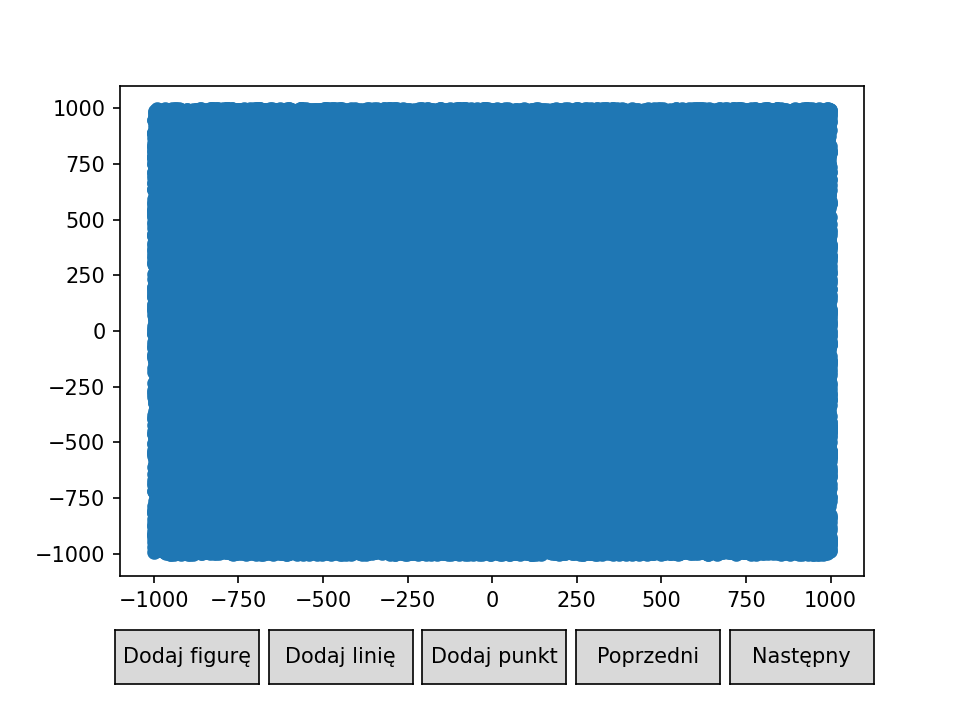

In [3]:
%matplotlib notebook
a_points = [(np.random.randint(-1000,1000), np.random.randint(-1000,1000)) for _ in range(10**5)]
plot = Plot(points = [PointsCollection(a_points)])
plot.draw()

Generuję zbiór punktów b

<IPython.core.display.Javascript object>


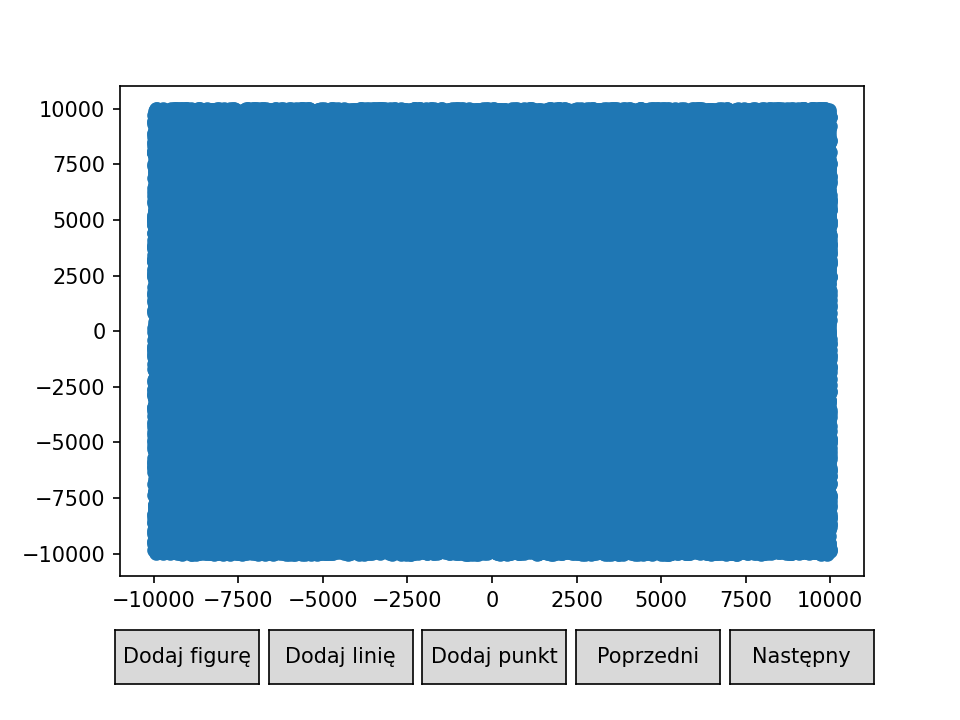

In [9]:
%matplotlib notebook
b_points = [(np.random.randint(-10**4,10**4),np.random.randint(-10**4,10**4)) for _ in range(10**5)]
plot = Plot(points = [PointsCollection(b_points)])
plot.draw()

Generuję zbiór punktów c

<IPython.core.display.Javascript object>


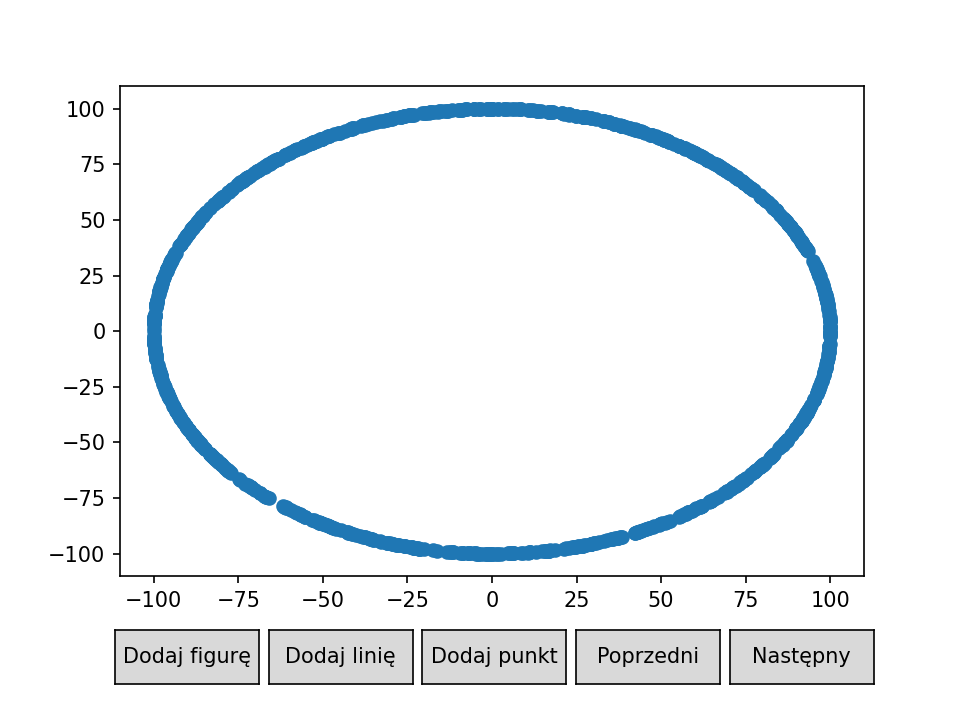

In [10]:
import math
%matplotlib notebook
radius = 100
c_points = []
for _ in range(1000):
    angle = np.random.rand()*(2*math.pi) #generuje kąt dla każdego punktu
    c_points.append((radius*math.cos(angle),radius*math.sin(angle))) #x = r*sin(angle) # y=r*cos(angle) 

plot = Plot(points = [PointsCollection(c_points)])
plot.draw()


Generuję zbiór punktów d

<IPython.core.display.Javascript object>


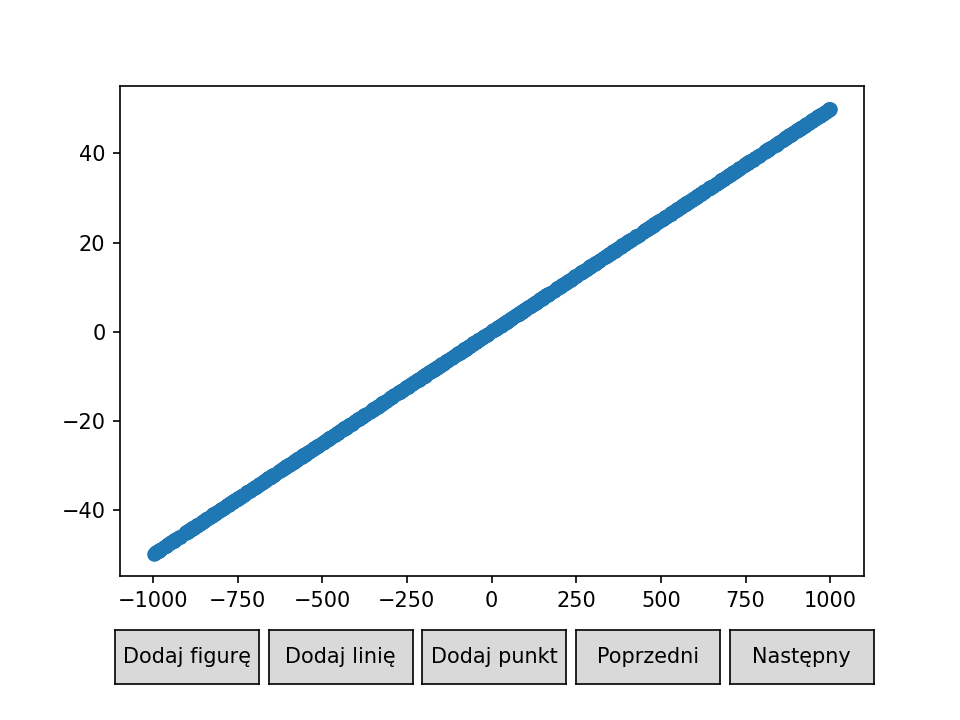

In [11]:
%matplotlib notebook
b = (1.0,0.1)
a = (-1.0,0.0)


d_points = []
for _ in range(1000):
    #select middle point between points
    m = [(a[0] + b[0]) / 2, (a[1] + b[1]) / 2]
    num = np.random.uniform(-1000,1000)
    x = ((b[0]-a[0])/2 * num + m[0])
    y = ((b[1]-a[1])/2 * num + m[1])
    d_points.append((x,y))
  
plot = Plot(points = [PointsCollection(d_points)])
plot.draw()


# Wyznaczniki i funkcja do podziału punktów

Funkcje do obliczania wyznaczników

In [12]:


def det3x3(a,b,c):
    #Reguła Sarrusa
    # |ax ay 1|
    # |bx by 1|
    # |cx cy 1|
    return a[0] * b[1] + b[0] * c[1] + a[1] * c[0] - (c[0]*b[1] + a[1] * b[0] + c[1] * a[0])
def det2x2(a,b,c):
    # wyznacznik 2x2
    # |ax-cx  ay-cy|
    # |bx-cx  by-cy|
    return (a[0] - c[0]) * (b[1]-c[1]) - (b[0]-c[0]) * (a[1] - c[1])

Funkcja do decydowania po której stronie znajduje się punkt

In [13]:
def pointLineSide(points, a =[-1.0,0.0], b = [1.0,0.1], e = 10**-14, libDet = True, detFunction = None, dim = 3, toPrint = True):
    
    #default determinant is numpy linalg.det 
    #default size of determinant is 3x3
    
    det = None #determinant function don't set if using numpy det
    
    def npDet3x3(a,b,c):
        matrix = np.array([[a[0],a[1],1],[b[0],b[1],1],[c[0],c[1],1]])
        return np.linalg.det(matrix)
    def npDet2x2(a,b,c):
        matrix = np.array([[a[0]-c[0],a[1]-c[1]],[b[0]-c[0],b[1]-c[1]]])
        return np.linalg.det(matrix)
    
    if libDet == True:
        if dim == 3:
            det = npDet3x3
        elif dim == 2:
            det = npDet2x2
        else:
            print("Set proper determinant dimension")
    if libDet == False:
        if detFunction is None:
            print("Set your own determinant function you want to use")
        else:
            det = detFunction
        
    
    left_side = []
    right_side = []
    along_line = []
    
    for point in points:
        determinant = det(a,b,point)
        if determinant > e:
            right_side.append(point)
        elif determinant < -1*e:
            left_side.append(point)
        else:
            along_line.append(point)
    if toPrint == True:
        print("Number of points to the left of the line: ",len(left_side))
        print("Number of points to the right of the line: ",len(right_side))
        print("Number of points on the line: ",len(along_line))
    
    return(left_side,right_side,along_line)

Funkcja rysująca wynik podziału

In [14]:
def print_points(result):
    left_side = result[0]
    right_side = result[1]
    along_line = result[2]
    plot = Plot(points = [PointsCollection(left_side,color = "green"),PointsCollection(right_side,color = "red"),PointsCollection(along_line, color = "purple")])
    plot.draw()

# Podział zbiorów, własny wyznacznik


Dziele punkty dla zbioru A wyznacznik 3x3 zaimplementowany samodzielnie

<IPython.core.display.Javascript object>


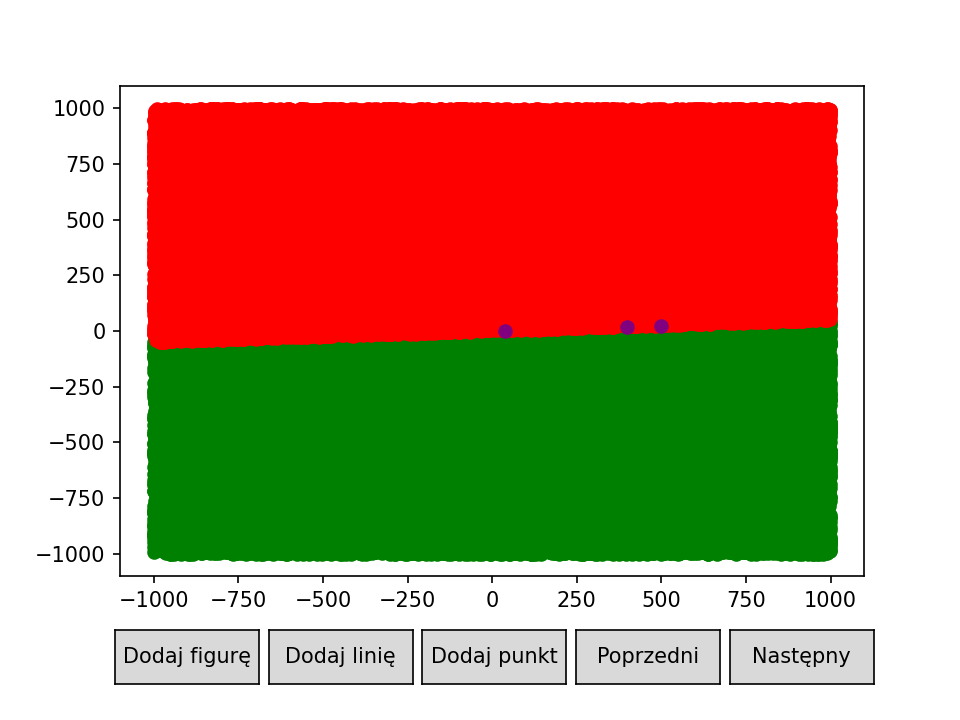

In [15]:
%matplotlib notebook
print_points(pointLineSide(a_points,libDet = False, detFunction = det3x3,toPrint = False))

Dziele punkty dla zbioru B wyznacznik 3x3 zaimplementowany samodzielnie

Number of points to the left of the line:  50010
Number of points to the right of the line:  49990
Number of points on the line:  0


<IPython.core.display.Javascript object>


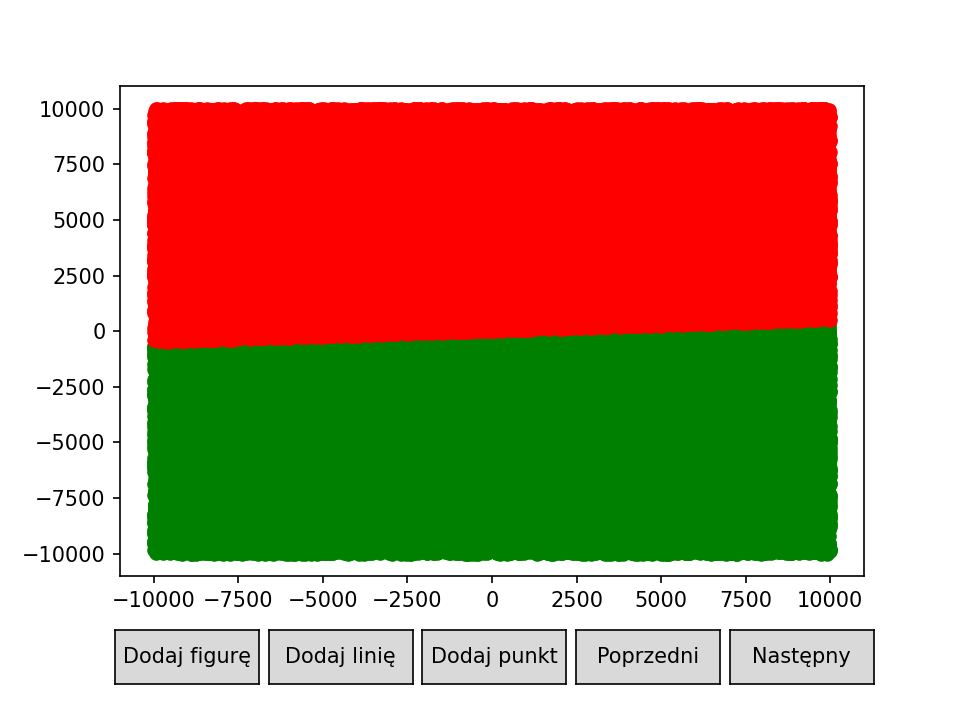

In [16]:
%matplotlib notebook
print_points(pointLineSide(b_points,libDet = False, detFunction = det3x3))

Dziele punkty dla zbioru C wyznacznik 3x3 zaimplementowany samodzielnie

Number of points to the left of the line:  481
Number of points to the right of the line:  519
Number of points on the line:  0


<IPython.core.display.Javascript object>


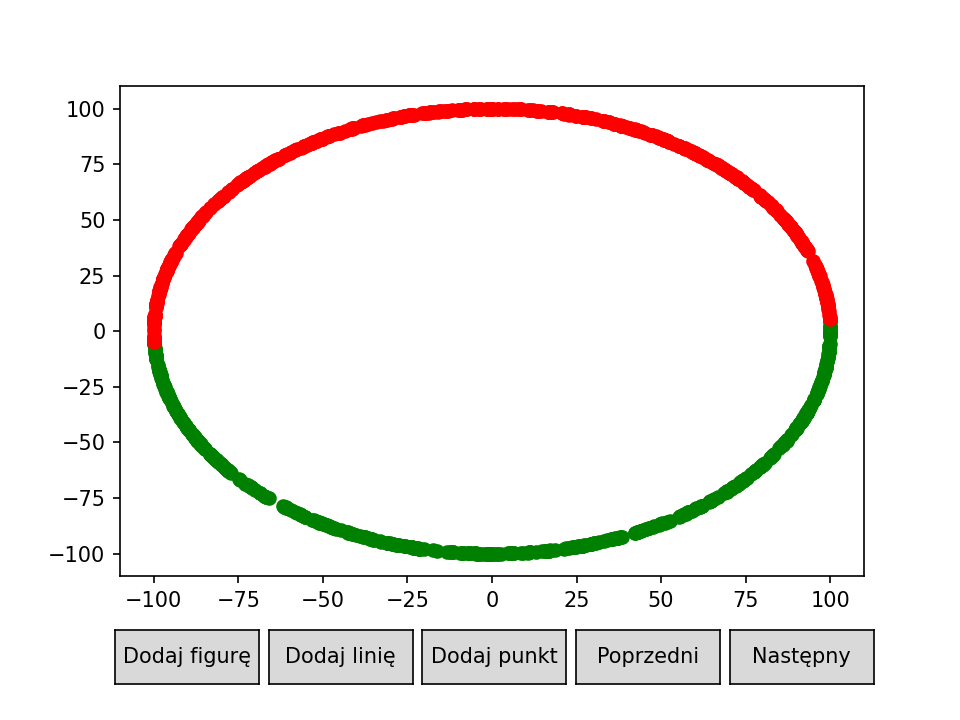

In [17]:
%matplotlib notebook
print_points(pointLineSide(c_points,libDet = False, detFunction = det3x3))

Dziele punkty dla zbioru D wyznacznik 3x3 zaimplementowany samodzielnie

Number of points to the left of the line:  0
Number of points to the right of the line:  0
Number of points on the line:  1000


<IPython.core.display.Javascript object>


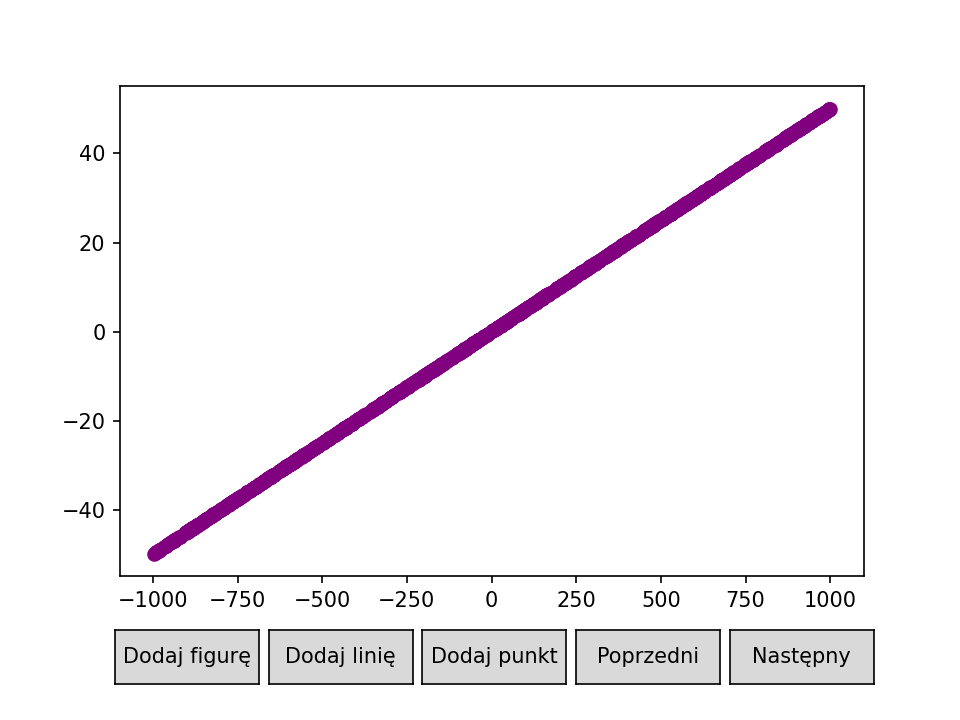

In [18]:
%matplotlib notebook
print_points(pointLineSide(d_points,libDet = False, detFunction = det3x3))

Dziele punkty dla zboru A wyznacznik 2x2 zaimplementowany samodzielnie

Number of points to the left of the line:  50235
Number of points to the right of the line:  49763
Number of points on the line:  2


<IPython.core.display.Javascript object>


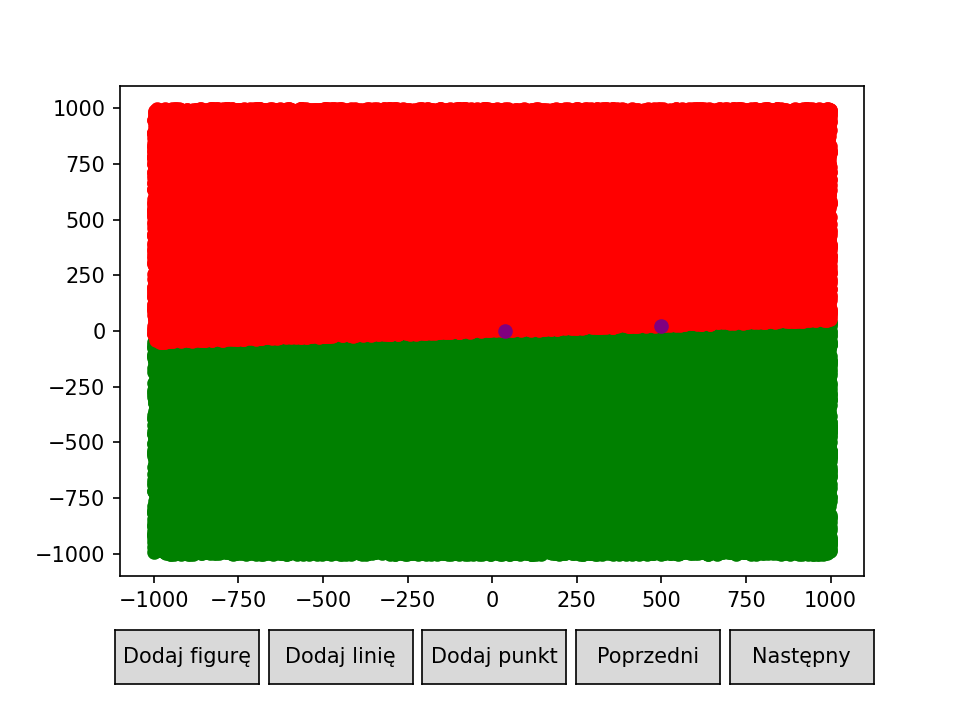

In [19]:
%matplotlib notebook
print_points(pointLineSide(a_points,libDet = False, detFunction = det2x2))

Dziele punkty dla zboru B wyznacznik 2x2 zaimplementowany samodzielnie

Number of points to the left of the line:  50010
Number of points to the right of the line:  49990
Number of points on the line:  0


<IPython.core.display.Javascript object>


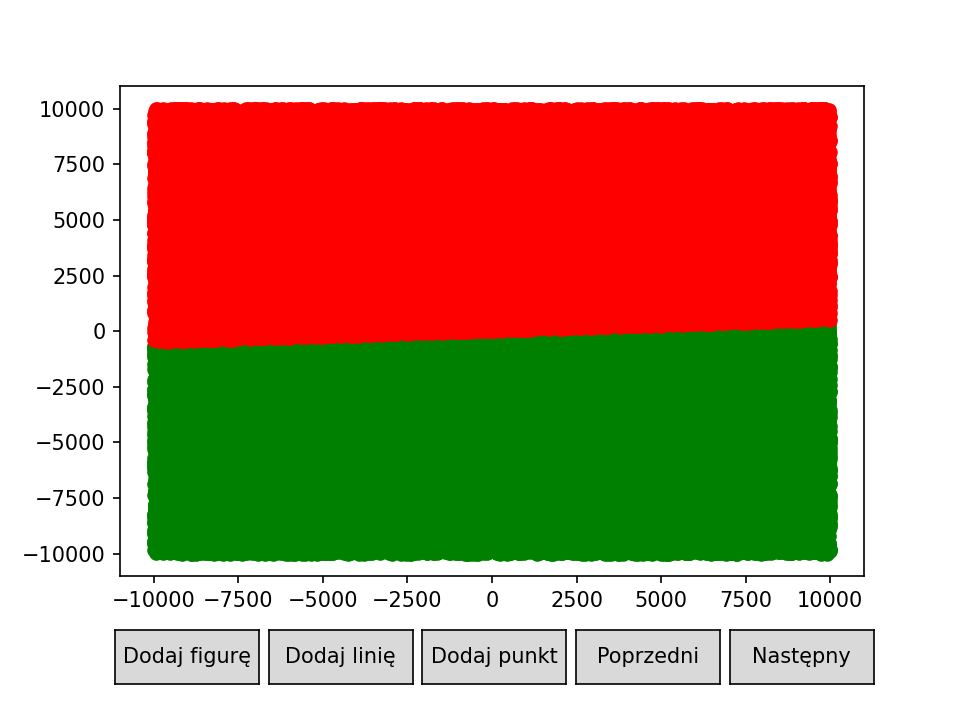

In [20]:
%matplotlib notebook
print_points(pointLineSide(b_points,libDet = False, detFunction = det2x2))

Dziele punkty dla zboru C wyznacznik 2x2 zaimplementowany samodzielnie

Number of points to the left of the line:  481
Number of points to the right of the line:  519
Number of points on the line:  0


<IPython.core.display.Javascript object>


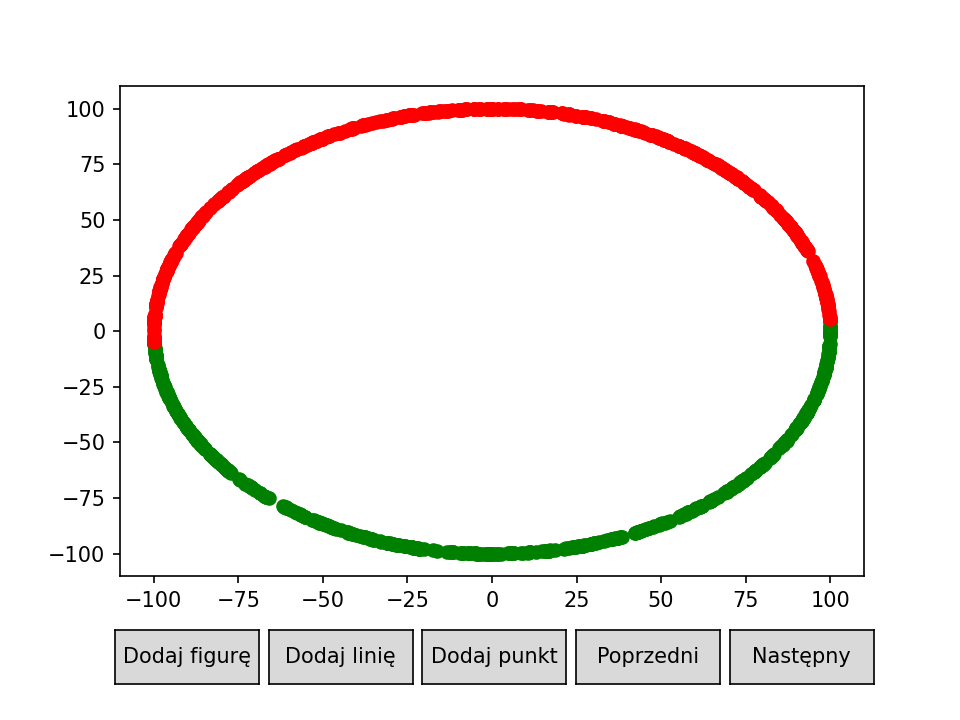

In [21]:
%matplotlib notebook
print_points(pointLineSide(c_points,libDet = False, detFunction = det2x2))

Dziele punkty dla zboru D wyznacznik 2x2 zaimplementowany samodzielnie

Number of points to the left of the line:  146
Number of points to the right of the line:  144
Number of points on the line:  710


<IPython.core.display.Javascript object>


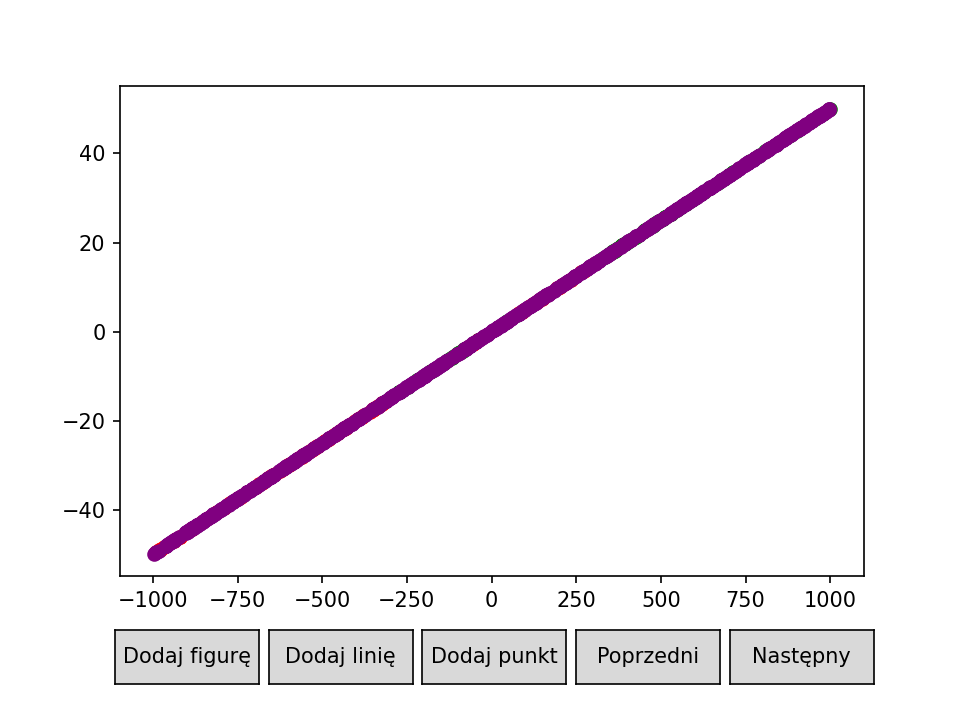

In [22]:
%matplotlib notebook
print_points(pointLineSide(d_points,libDet = False, detFunction = det2x2))

# Podział zbiorów, wyznacznik numpy

Dziele punkty dla zbioru A wyznacznik 3x3 z biblioteki numpy

In [ ]:
%matplotlib notebook
print_points(pointLineSide(a_points,libDet = True, dim = 3))

Dziele punkty dla zbioru B wyznacznik 3x3 z biblioteki numpy

In [ ]:
%matplotlib notebook
print_points(pointLineSide(b_points,libDet = True, dim = 3))

Dziele punkty dla zbioru C wyznacznik 3x3 z biblioteki numpy

In [ ]:
%matplotlib notebook
print_points(pointLineSide(c_points,libDet = True, dim = 3))

Dziele punkty dla zbioru D wyznacznik 3x3 z biblioteki numpy

In [ ]:
%matplotlib notebook
print_points(pointLineSide(d_points,libDet = True, dim = 3))

Dziele punkty dla zbioru A wyznacznik 2x2 z biblioteki numpy

In [ ]:
%matplotlib notebook
print_points(pointLineSide(a_points,libDet = True, dim = 2))

Dziele punkty dla zbioru B wyznacznik 2x2 z biblioteki numpy

In [ ]:
%matplotlib notebook
print_points(pointLineSide(b_points,libDet = True, dim = 2))

Dziele punkty dla zbioru C wyznacznik 2x2 z biblioteki numpy

In [ ]:
%matplotlib notebook
print_points(pointLineSide(c_points,libDet = True, dim = 2))

Dziele punkty dla zbioru D wyznacznik 2x2 z biblioteki numpy

In [ ]:
%matplotlib notebook
print_points(pointLineSide(d_points,libDet = True, dim = 2))

# Porównanie metod

Funkcja do obliczania i rysowania różnicy w podziale punktów 

In [7]:
def diff(list1,list2,toPrint = True,draw = False):
    #funkcja wypisuje ile punktów zostało inaczej zaklasyfikowanych
    points = []
    
    
    map1 = [[point,"left"] for point in list1[0]]
    map1.extend([[point,"right"] for point in list1[1]])
    map1.extend([[point,"alongline"] for point in list1[2]])
    map1.sort()
    
    map2 = [[point,"left"] for point in list2[0]]
    map2.extend([[point,"right"] for point in list2[1]])
    map2.extend([[point,"alongline"] for point in list2[2]])
    map2.sort()
    
    for i in range(len(map1)):
        if map1[i][1] != map2[i][1]:
            points.append(map1[i][0])
    
        
    
    if toPrint == True:
        print(len(points))
    if draw == True:
        plot = Plot(points = [PointsCollection(points)])
        plot.draw()
        
    

Różnica miedzy podziałem punktów ze zbioru A przy użyciu wyznacznika samodzielnej implementacji 3x3 a wyznacznika 3x3 z biblioteki numpy


1


<IPython.core.display.Javascript object>


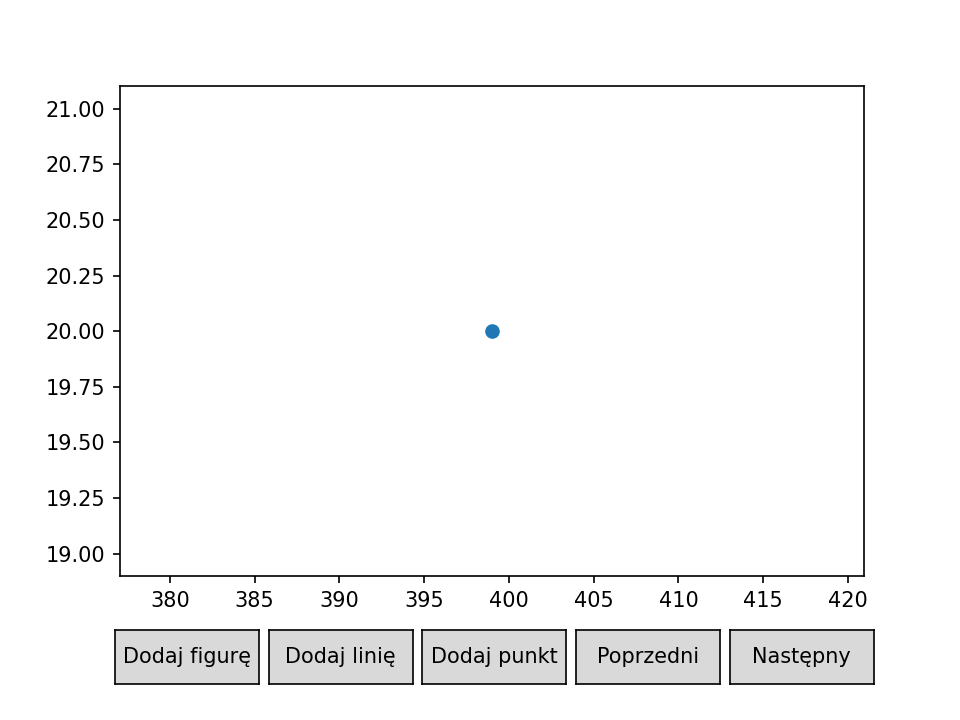

In [8]:

l1 = pointLineSide(a_points,libDet = True,dim = 2, toPrint = False)
l2 = pointLineSide(a_points,libDet = False, detFunction = det2x2, toPrint = False)

diff(l1,l2,draw = True)

Różnica miedzy podziałem punktów ze zbioru B przy użyciu wyznacznika samodzielnej implementacji 3x3 a wyznacznika 3x3 z biblioteki numpy

In [ ]:
l1 = pointLineSide(b_points,libDet = True,dim = 2, toPrint = False)
l2 = pointLineSide(b_points,libDet = False, detFunction = det2x2,toPrint = False)

diff(l1,l2,draw = False)

Różnica miedzy podziałem punktów ze zbioru C przy użyciu wyznacznika samodzielnej implementacji 2x2 a wyznacznika 2x2 z biblioteki numpy

In [ ]:
l1 = pointLineSide(c_points,libDet = True,dim = 2, toPrint = False)
l2 = pointLineSide(c_points,libDet = False, detFunction = det2x2, toPrint = False)

diff(l1,l2,draw = False)

# Porównanie dla różych tolerancji


dokładność e = 10^10-14, wyznacznik własnej implementacji a wyznacznik z biblioteki numpy

In [ ]:
l1 = pointLineSide(d_points,e = 10**-14,libDet = True,dim = 2, toPrint = False)
l2 = pointLineSide(d_points,e = 10**-14,libDet = False, detFunction = det2x2,  toPrint = False)


diff(l1,l2,draw = True)

dokładność e = 10^10-13, wyznacznik własnej implementacji a wyznacznik z biblioteki numpy

In [ ]:
l1 = pointLineSide(d_points,e = 10**-13,libDet = True,dim = 2, toPrint = False)
l2 = pointLineSide(d_points,e = 10**-13,libDet = False, detFunction = det2x2,  toPrint = False)

diff(l1,l2,draw = True)

dokładność e = 10^10-12, wyznacznik własnej implementacji a wyznacznik z biblioteki numpy

In [ ]:
l1 = pointLineSide(d_points,e = 10**-12,libDet = True,dim = 2,  toPrint = False)
l2 = pointLineSide(d_points,e = 10**-12,libDet = False, detFunction = det2x2, toPrint = False)

diff(l1,l2,draw = True)

dokładność e = 10^10-13, wyznacznik własnej implementacji a wyznacznik z biblioteki numpy

In [ ]:
l1 = pointLineSide(d_points,e = 0,libDet = True,dim = 2,  toPrint = False)
l2 = pointLineSide(d_points,e = 0,libDet = False, detFunction = det2x2,  toPrint = False)

diff(l1,l2,draw = True)

Na koniec jeszcze porównanie czasów działania

In [ ]:
import time
startTime = time.time()
pointLineSide(a_points,libDet = True,dim = 3,  toPrint = False)
print("Podział przy użyciu wyznacznika z biblioteki numpy, czas operacji: ",time.time() - startTime,"sekund")

startTime = time.time()
pointLineSide(a_points,libDet = False, detFunction = det3x3, toPrint = False)
print("Podział przy użyciu wyznacznika własnej implementacji, czas operacji: ",time.time() - startTime,"sekund")